<a href="https://colab.research.google.com/github/vivi1231/0813/blob/master/01lymphoma_CNN_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

In [3]:
IMG_SIZE = 256
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

In [34]:
# Read single image
data_path = 'drive/My Drive/Day4/lymphoma/*/*.tif' 
img_paths = glob(data_path)
# img_paths = np.random.choice(img_paths, 100) # 100 images only for demo

print('number of images', len(img_paths))

number of images 374


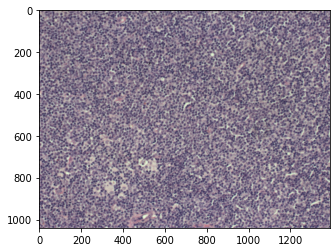

In [35]:
img = cv2.imread(img_paths[0])[:,:,::-1] # BGR -> RGB
plt.imshow(img)

((1040, 1388, 3), (256, 256, 3))

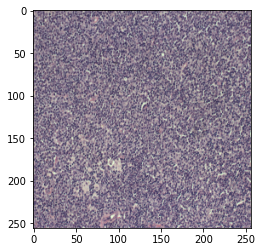

In [36]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [37]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/Day4/lymphoma/CLL/sj-05-3874-R2_001.tif'

In [38]:
cls = img_path.split('/')[-2]
cls

'CLL'

In [39]:
class_map[cls]

0

In [40]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [41]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)[:,:,::-1] # BGR -> RGB
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255. # normalize 0~255 -> 0~1
    
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [42]:
# label count
unique_classes, counts = np.unique(y, return_counts=True)
unique_classes, counts

(array([0., 1., 2.]), array([113, 122, 139]))

In [43]:
# One-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=3)

In [44]:
# Split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 256, 256, 3), (75, 256, 256, 3), (299, 3), (75, 3))

### Build model

In [45]:
# model 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=17, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=31, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [46]:
# model2
model2 = tf.keras.models.Sequential()
model2.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model2.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=17, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(filters=31, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(3, activation='softmax'))

In [47]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 252, 252, 17)      2465      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 17)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 124, 124, 31)      4774      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 122, 122, 32)      8960      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 32)       

In [ ]:
# show model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [49]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [50]:
logs = model.fit(X_train, y_train,
                batch_size=16, #一次丟幾張
                epochs=50,   #幾輪
                verbose=1,
                validation_data=(X_test, y_test))

Epoch 1/50
19/19 [==============================] - 3s 142ms/step - loss: 42.8736 - accuracy: 0.2910 - val_loss: 1.0982 - val_accuracy: 0.3067
Epoch 2/50
19/19 [==============================] - 2s 85ms/step - loss: 1.0984 - accuracy: 0.3880 - val_loss: 1.0985 - val_accuracy: 0.3467
Epoch 3/50
19/19 [==============================] - 2s 85ms/step - loss: 1.0957 - accuracy: 0.3512 - val_loss: 1.0957 - val_accuracy: 0.3600
Epoch 4/50
19/19 [==============================] - 2s 85ms/step - loss: 1.1774 - accuracy: 0.3913 - val_loss: 1.0976 - val_accuracy: 0.3600
Epoch 5/50
19/19 [==============================] - 2s 87ms/step - loss: 1.0971 - accuracy: 0.3779 - val_loss: 1.0978 - val_accuracy: 0.3600
Epoch 6/50
19/19 [==============================] - 2s 86ms/step - loss: 1.0962 - accuracy: 0.3746 - val_loss: 1.0981 - val_accuracy: 0.3600
Epoch 7/50
19/19 [==============================] - 2s 87ms/step - loss: 1.0942 - accuracy: 0.4047 - val_loss: 1.0977 - val_accuracy: 0.3600
Epoch 8/50


In [51]:
history = logs.history

Text(0.5, 1.0, 'acc')

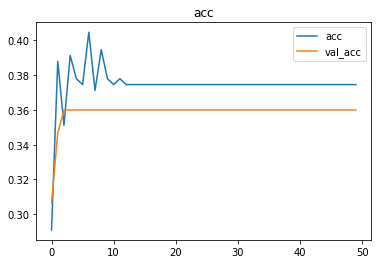

In [52]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

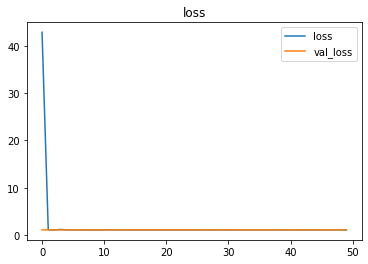

In [53]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

### Metrics

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

model_pred = model.predict(X_test)
y_pred = np.argmax(model_pred, axis=-1)

y_true = np.argmax(y_test, axis=-1)
print(y_true.shape, y_pred.shape)
print('ground truth: ', y_true[:5])
print('model pred: ', y_pred[:5])

(75,) (75,)
ground truth:  [0 0 1 2 2]
model pred:  [2 2 2 2 2]


In [ ]:
# classification_report
target_names = ['CLL', 'MCL', 'FL']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# confusion_matrix
# row: ground truth class
# column: prediction class
print(confusion_matrix(y_true, y_pred))